# Convolutional Autoencoder (CAE)
### Authors: Sergi Nogués and Gilles Salem

This is the second assignment for ACML at the MSc in
Artificial Intelligence at Maastricht University.

[Source code](https://github.com/serginogues/convolutional_autoencoder)

CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import torch
from torchvision import datasets
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_PATH = 'D:/UM/ACML/Assignments/'
VALIDATION_SIZE = 0.1  # percentage of the training set used for validation
TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
BATCH_SIZE = 64
# Compatibility with CUDA and GPU -> remember to move into GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

_Divide your dataset into training (80%), validation (10%) and test (10%). Normalize the data:_

Files already downloaded and verified
Files already downloaded and verified
image label: truck
torch.Size([3, 32, 32])


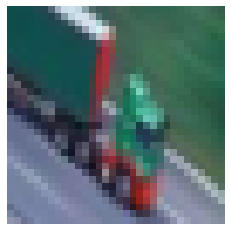


# samples train set = 48000
# samples test set = 6000
# samples validation set = 6000
Sample distribution: 80% train, 10% test, 10% validation


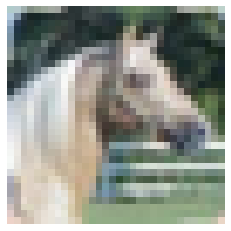

In [3]:
train_dataset = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())
classes = train_dataset.classes

img, label = train_dataset[50]
print("image label:", classes[label])

# since we already used the transform, type(img) = torch.Tensor
print(img.shape)

# plot with original axis before converting PIL Image to Tensor, otherwise an Exception arises
# C × H × W to H × W × C
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

concat_dataset = ConcatDataset([train_dataset, test_dataset])
len_ = len(concat_dataset)
train_set, test_set, valid_set = random_split(concat_dataset, [round(len_ * TRAIN_SIZE), round(len_ * TEST_SIZE), round(len_ * VALIDATION_SIZE)])

print("")
print("# samples train set =", len(train_set))
print("# samples test set =", len(test_set))
print("# samples validation set =", len(valid_set))
total_samp = len(train_set) + len(test_set) + len(valid_set)
print("Sample distribution: " + str(round((len(train_set) / total_samp) * 100))
      + "% train, " + str(round((len(test_set) / total_samp) * 100)) + "% test, "
      + str(round((len(valid_set) / total_samp) * 100)) + "% validation")

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

Xs, Ys = iter(train_loader).next()
images = Xs.numpy()
images = images
plt.imshow(np.transpose(images[30], (1, 2, 0)))
plt.axis('off')
plt.show()

_Implement the autoencoder network specified above. Run the training for at least 10 epochs, and plot the
evolution of the error with epochs._

In [4]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [5]:
class CAE(nn.Module):
    def __init__(self, channels, padding = 1, stride = 1, kernel = 3):
        super(CAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels[0], kernel_size=kernel, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=kernel, padding=padding, stride=stride)
        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=kernel, padding=padding, stride=stride)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel-1, stride=stride, padding=0)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[3], kernel_size=kernel+1, padding=padding, stride=stride)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=3, kernel_size=kernel+1, padding=padding, stride=stride)
        self.print_latent_shape = 0

    def forward(self, x):
        # encoder
        x1 = F.relu(self.conv1(x))

        x2 = self.maxpool(x1)
        x3 = F.relu(self.conv2(x2))
        x4 = self.maxpool(x3)
        x5 = F.relu(self.conv3(x4))

        # decoder
        x6 = F.relu(self.t_conv1(x5))
        y = F.sigmoid(self.t_conv2(x6))

        if self.print_latent_shape == 0:
            print(str(x1.shape) + " -> " + str(x2.shape) + " -> " + str(x3.shape) + " -> ")
            print(str(x4.shape) + " -> Latent space:" + str(x5.shape) + " -> " + str(x6.shape) + " -> " + str(y.shape))
            self.print_latent_shape +=1

        return y

In [6]:
from tqdm import tqdm
EPOCHS = 10
SAVE_PATH = 'models/cae.pth'
SAVE_PATH2 = 'models/cae2.pth'
SAVE_PATH3 = 'models/cae3.pth'
TRAIN = True
LR = 0.01
channels = [8, 12, 16, 12]

model = CAE(channels=channels).to(device)
criterion = nn.BCELoss()  # loss function
#optimizer = optim.SGD(model.parameters(), lr=LR)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

c:\users\nogue\.virtualenvs\sergi_env\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([64, 8, 32, 32]) -> torch.Size([64, 8, 31, 31]) -> torch.Size([64, 12, 31, 31]) -> 
torch.Size([64, 12, 30, 30]) -> Latent space:torch.Size([64, 16, 30, 30]) -> torch.Size([64, 12, 31, 31]) -> torch.Size([64, 3, 32, 32])
Epoch 0, Loss = 0.5804584779706279
Epoch 1, Loss = 0.5670777036048065
Epoch 2, Loss = 0.5595353805073437
Epoch 3, Loss = 0.556492256341789
Epoch 4, Loss = 0.5554542056074774
Epoch 5, Loss = 0.5550775700934583
Epoch 6, Loss = 0.5549349799732975
Epoch 7, Loss = 0.5545720961281708
Epoch 8, Loss = 0.5545965287049401
Epoch 9, Loss = 0.5544914552736981
Training finished


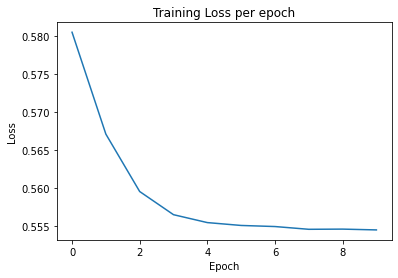

In [7]:
def train(model, SAVE_PATH=SAVE_PATH):
    loss_history = []
    running_loss = 0.0
    for i in range(EPOCHS):
        # TRAIN MODEL
        loss_sum = 0
        n = 0
        for j, data in enumerate(train_loader, 0):
            n = j
            # get the training data
            images, label = data
            images = images.to(device)

            # Before the backward pass, set gradients to zero
            optimizer.zero_grad()

            # predict
            output = model.forward(images)

            # compute loss
            loss = criterion(output, images)
            loss_sum += round(float(loss.item()), 4)

            # backpropagate loss error
            loss.backward()

            # optimize with backprop
            optimizer.step()
            del data, images, label

        # region print current loss
        loss_epoch = loss_sum/n
        loss_history.append(loss_epoch)
        print("Epoch "+ str(i) +", Loss = "+ str(loss_epoch))

    # SAVE THE MODEL
    torch.save(model.state_dict(), SAVE_PATH)
    print("Training finished")

    # PLOT ACCURACY
    plt.plot(loss_history)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss per epoch')
    plt.show()

train(model)

_Report also the test error._

In [8]:
def load_model(path = SAVE_PATH):
    model = CAE(channels)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def test(trained_model):
    with torch.no_grad():
        loss_sum = 0
        n = 0
        for images, labels in test_loader:
            output = trained_model.forward(images)
            loss = criterion(output, images)
            loss_sum += round(float(loss.item()), 4)
            n += 1
        loss_final = loss_sum/n
        print("Test Loss = ", loss_final)

trained_model = load_model(SAVE_PATH)
test(trained_model)

torch.Size([64, 8, 32, 32]) -> torch.Size([64, 8, 31, 31]) -> torch.Size([64, 12, 31, 31]) -> 
torch.Size([64, 12, 30, 30]) -> Latent space:torch.Size([64, 16, 30, 30]) -> torch.Size([64, 12, 31, 31]) -> torch.Size([64, 3, 32, 32])
Test Loss =  0.5525797872340427


We now test our trained model with these 5 images:

<ipython-input-9-9863a18850b2>:8: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


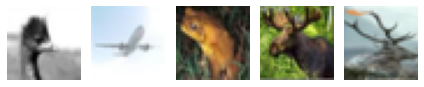

In [9]:
images, labels = iter(test_loader).next()
images_plot = images.numpy()

ff, axarr = plt.subplots(1, 5, constrained_layout=True)
for i in range(5):
    axarr[i].imshow(np.transpose(images_plot[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

After 10 epochs of training our model does a good reconstruction:

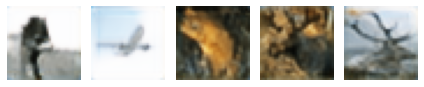

In [10]:
# Sample outputs
output = trained_model.forward(images)
output = output.detach().numpy()

ff2, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(np.transpose(output[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

_What is the size of the latent space representation of the above network?_

conv filter formula: $W' = \frac{W - K + 2P}{S} + 1$

Encoder:
1. out_conv1 = batch_size x 8 x 32 x 32 where $32 = 32 - 3 + 2 + 1$
- out_pool1 = batch_size x 8 x 31 x 31
- out_conv2 = batch_size x 12 x 31 x 31
- out_pool2 = batch_size x 12 x 30 x 30
- out_conv3 = batch_size x 16 x 30 x 30

Latent space size = 16 x 30 x 30 = 14400

_Try other architectures (e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) to answer questions such as: What is the impact of those in the reconstruction error
after training? Is there an obvious correlation between the size of the latent space representation and the error?_

In [12]:
channels = [5, 8, 10, 8]

class CAE2(nn.Module):
    def __init__(self, channels, padding = 1, stride = 1, kernel = 3):
        super(CAE2, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=channels[0], kernel_size=kernel, padding=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=kernel, padding=padding, stride=2)
        self.conv3 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=kernel, padding=padding, stride=stride)
        self.maxpool = nn.MaxPool2d(kernel_size=kernel-1, stride=stride, padding=0)

        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[3], kernel_size=15, padding=padding, stride=stride)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=3, kernel_size=16, padding=padding, stride=stride)
        self.print_latent_shape = 0

    def forward(self, x):
        # encoder
        x1 = F.relu(self.conv1(x))

        x2 = self.maxpool(x1)
        x3 = F.relu(self.conv2(x2))
        x4 = self.maxpool(x3)
        x5 = F.relu(self.conv3(x4))

        # decoder
        x6 = F.relu(self.t_conv1(x5))
        y = F.sigmoid(self.t_conv2(x6))

        if self.print_latent_shape == 0:
            print(str(x1.shape) + " -> " + str(x2.shape) + " -> " + str(x3.shape) + " -> ")
            print(str(x4.shape) + " -> Latent space:" + str(x5.shape) + " -> " + str(x6.shape) + " -> " + str(y.shape))
            self.print_latent_shape +=1

        return y


model = CAE2(channels=channels).to(device)

criterion = nn.BCELoss()  # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train(model, SAVE_PATH=SAVE_PATH2)

model = load_model(SAVE_PATH2)
test(model)

c:\users\nogue\.virtualenvs\sergi_env\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([64, 5, 17, 17]) -> torch.Size([64, 5, 16, 16]) -> torch.Size([64, 8, 8, 8]) -> 
torch.Size([64, 8, 7, 7]) -> Latent space:torch.Size([64, 10, 7, 7]) -> torch.Size([64, 8, 19, 19]) -> torch.Size([64, 3, 32, 32])
Epoch 0, Loss = 0.6921174899866491
Epoch 1, Loss = 0.6920026702269689
Epoch 2, Loss = 0.692003337783711
Epoch 3, Loss = 0.6920072096128166
Epoch 4, Loss = 0.691991855807744


KeyboardInterrupt: 

In [ ]:
# Sample outputs
output = model.forward(images)
output = output.detach().numpy()

ff2, axarr = plt.subplots(1, 5)
for i in range(5):
    axarr[i].imshow(np.transpose(output[i], (1, 2, 0)))
    axarr[i].axis('off')
plt.tight_layout()
plt.show()

Now the latent space has size 10 x 7 x 7.
This is much smaller compared to the previous configuration (16 x 30 x 30).
Consequently the reconstruction error is higher.

_Adapt your network from the previous part such that it learns to reconstruct colors by feeding in grayscale
images but predicting all RGB channels. As a starting point, use the hyperparameters (including the network
architecture) that you identified to yield the best performance in Exercise 3.2._

_Report on your results and reason about potential shortcomings of your network. What aspects of the architecture/hyperparameters/optimization could be improved upon to fit the model more adequately to this
application? Try out some ideas._